# Paris Saclay Center for Data Science : prédiction du nombre de passagers aériens


---
## Introduction


---

L'ensemble de données nous a été donné par une société anonyme qui s'occupe de la réservation des billets d'avion. Les données contiennent : 

- la date de départ
- l'aéroport de départ
- l'aéroport d'arrivée
- la moyenne et l'écart-type du nombre de semaines des réservations effectuées avant la date de départ
- un champ appelé `log_PAX` qui est lié au nombre de passagers (le nombre réel a été modifié pour des raisons de confidentialité)

L'objectif est de prédire la colonne `log_PAX`. La qualité de la prédiction est mesurée par RMSE.

Les données sont évidemment limitées, mais comme les données et les informations de localisation sont disponibles, elles peuvent être jointes à des données externes. Le défi de ce RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien.

In [2]:
import os
from distance_calcul import distance
from scipy.stats import mode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from describe import stats_histo
import problem
import warnings
import shap

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

---
## Chargement des données
---

Les données relatives à la formation et aux tests se trouvent dans le dossier `data`. Elles sont compressées dans un fichier `csv` (c'est-à-dire `csv.bz2`). Nous pouvons charger l'ensemble de données en utilisant des pandas.

In [3]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [4]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [5]:
X_train.DateOfDeparture.min(), X_train.DateOfDeparture.max()

('2011-09-01', '2013-03-05')

La colonne `log_PAX` est la cible de notre problème de régression. Les autres colonnes sont les caractéristiques qui seront utilisées pour la prédiction.

`Departure` et `Arrival` sont le code de l'aéroport. Toutefois, nous voyons que la `DateOfDeparture` devrait être une date au lieu d'une chaîne de caractères. Nous pouvons utiliser des pandas pour convertir ces données.

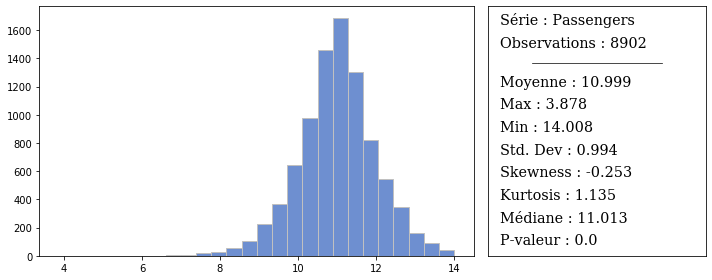

In [6]:
stats_histo(y_train, 'Passengers')

---
## Préprocessing
---

Pour ce projet, nous avons effectué toutes les étapes de prétraitement dans le cadre d’une pipeline scikit-learn qui enchaîne les étapes de transformation puis d’estimation. 

Nous allons créer des fonctions de préprocessing et utiliser `FunctionTransformer` pour la rendre compatible avec l’API scikit-learn. En effet, le retour du programme sur la plateforme RAMP doit être une pipeline scikit-learn (donc un objet qu’on peut fit et transform).

### Transformeurs : préprocessing des dates

Un dictionnaire qu'on va utiliser :
```python
external_dico['PHL']['lat']
```

In [7]:
external_dico = {'PHL': {'lat': 39.87195, 'long': -75.24114, 'state': 'Pennsylvania', 'altitude': 36, 'tz': 'New_York', 'pop_2010': 1584138}, 
                 'DFW': {'lat': 32.89595, 'long': -97.0372, 'state': 'Texas', 'altitude': 607, 'tz': 'Chicago', 'pop_2010': 1345047}, 
                 'IAH': {'lat': 29.98047, 'long': -95.33972, 'state': 'Texas', 'altitude': 97, 'tz': 'Chicago', 'pop_2010': 2325502}, 
                 'ATL': {'lat': 33.640440000000005, 'long': -84.42694, 'state': 'Georgia', 'altitude': 1026, 'tz': 'New_York', 'pop_2010': 498044}, 
                 'BOS': {'lat': 42.36435, 'long': -71.00518000000001, 'state': 'Massachusetts', 'altitude': 20, 'tz': 'New_York', 'pop_2010': 694583}, 
                 'LAX': {'lat': 33.94254, 'long': -118.40807, 'state': 'California', 'altitude': 125, 'tz': 'Los_Angeles', 'pop_2010': 3990456}, 
                 'SFO': {'lat': 37.619, 'long': -122.37483999999999, 'state': 'California', 'altitude': 13, 'tz': 'Los_Angeles', 'pop_2010': 883305}, 
                 'EWR': {'lat': 40.6925, 'long': -74.16866, 'state': 'New Jersey', 'altitude': 18, 'tz': 'New_York', 'pop_2010': 8398748}, 
                 'JFK': {'lat': 40.63975, 'long': -73.77893, 'state': 'New York', 'altitude': 13, 'tz': 'New_York', 'pop_2010': 8398748}, 
                 'LGA': {'lat': 40.77724, 'long': -73.87261, 'state': 'New York', 'altitude': 21, 'tz': 'New_York', 'pop_2010': 8398748}, 
                 'DTW': {'lat': 42.21206, 'long': -83.34884, 'state': 'Michigan', 'altitude': 645, 'tz': 'New_York', 'pop_2010': 672662}, 
                 'DEN': {'lat': 39.85841, 'long': -104.667, 'state': 'Colorado', 'altitude': 5431, 'tz': 'Denver', 'pop_2010': 716492}, 
                 'CLT': {'lat': 35.214009999999995, 'long': -80.94313000000001, 'state': 'North Carolina', 'altitude': 748, 'tz': 'New_York', 'pop_2010': 872498}, 
                 'MSP': {'lat': 44.88055, 'long': -93.21692, 'state': 'Minnesota', 'altitude': 841, 'tz': 'Chicago', 'pop_2010': 425403}, 
                 'SEA': {'lat': 47.44898, 'long': -122.30931000000001, 'state': 'Washington', 'altitude': 433, 'tz': 'Los_Angeles', 'pop_2010': 744955}, 
                 'ORD': {'lat': 41.9796, 'long': -87.90446, 'state': 'Illinois', 'altitude': 672, 'tz': 'Chicago', 'pop_2010': 2705994}, 
                 'MCO': {'lat': 28.428890000000003, 'long': -81.31603, 'state': 'Florida', 'altitude': 96, 'tz': 'New_York', 'pop_2010': 285713}, 
                 'MIA': {'lat': 25.79325, 'long': -80.29056, 'state': 'Florida', 'altitude': 8, 'tz': 'New_York', 'pop_2010': 470914}, 
                 'LAS': {'lat': 36.08036, 'long': -115.15233, 'state': 'Nevada', 'altitude': 2181, 'tz': 'Los_Angeles', 'pop_2010': 644644}, 
                 'PHX': {'lat': 33.43417, 'long': -112.00806000000001, 'state': 'Arizona', 'altitude': 1135, 'tz': 'Phoenix', 'pop_2010': 1660272}}


La mise en colonnes numériques des dates est une opération courante lorsque les données des séries chronologiques sont analysées à l'aide de prédicteurs non paramétriques. Le code ci-dessous permet d'effectuer les transformations suivantes :

- colonnes numériques pour l'année (2011-2012) 
- le mois (1-12) 
- le jour du mois (1-31),
- la semaine de l'année (1-52)

In [8]:
def parse_date(x):
    date = pd.to_datetime(x, format="%Y-%m-%d")
    return pd.Series([date.year, date.month, date.weekday(), date.week])

In [9]:
from sklearn.preprocessing import FunctionTransformer

def _encoder_dates(X):
    X[["year","month","weekday","week"]] = X[
    "DateOfDeparture"].apply(parse_date)
    return X

date_encoder = FunctionTransformer(_encoder_dates)

In [10]:
date_encoder.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8


### Transformeur : calcul des distances et population

À partir du dictionnaire (position géographique et population des aéroports), on applique la fonction de calcul des distances entre les aéroports de départ et d’arrivé, pour chaque ligne (une variable).

> **La distance** : la distance en kilomètres entre l’aéroport d’arrivée et de départ est un facteur à prendre en compte car il représente la taille de l’avion selon s’il s’agit d’un vol long-courrier, ou non. Pour cela, nous avons utilisé une base [Kaggle](https://www.kaggle.com/usdot/flight-delays%23airports.csv) pour récupérer la lattitude et la longitude de chaque aéroport et une fonction distance pour la calculer. Pour éviter de les intégrer dans le jeu de données externes, nous avons créé un dictionnaire au sein de la fonction, prenant pour clé l’aéroport et en valeur la position géographique.

In [11]:
def compute_dist(X):   
    X["Distance"] = X.apply(lambda x : 
                            distance((external_dico[x["Departure"]]['lat'],
                                      external_dico[x["Departure"]]['long']),
                                     (external_dico[x["Arrival"]]['lat'], 
                                      external_dico[x["Arrival"]]['long'])), axis=1)
    return X

dist_ = FunctionTransformer(compute_dist)

In [12]:
dist_.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,Distance
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,1290.779961
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,1009.721628
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,1385.461051
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,976.057905
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,1553.249207


On fait de même avec la population en utilisant ce même dictionnaire qui contient la population de chacune des villes des aéroports de départ et d’arrivé (deux variables).

> **L’ajout de la population de la ville** : le nombre de vols entre deux aéroports dépend probablement du nombre de personnes présentes dans les villes respectives. À partir des données de [Wikipédia](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) provenant de Census.gov, nous avons ajouté au dictionnaire précédent la population de chaque aéroport (plus précisément la ville dont dépend l’aéroport), sur l’année 2010.

In [13]:
def merge_population (X):   
    X["population_Arrival"] = X.apply(lambda x : 
                       external_dico[x["Arrival"]]['pop_2010'], axis=1)
    
    X["population_departure"] = X.apply(lambda x : 
                       external_dico[x["Departure"]]['pop_2010'], axis=1)                
    return X

popu = FunctionTransformer(merge_population)

In [14]:
popu.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,Distance,population_Arrival,population_departure
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,1290.779961,1345047,2705994
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,1009.721628,716492,644644
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,1385.461051,3990456,716492
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,976.057905,2705994,498044
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,1553.249207,883305,716492


### Transformeur : utiliser les données externes

L'objectif de ce défi de données RAMP est de trouver de bonnes données qui peuvent être corrélées au trafic aérien. Nous utiliserons quelques données externes (enregistrées dans `submissions/submit`).

Nous allons d'abord définir une fonction qui fusionne les données externes à nos données de caractéristiques.

In [15]:
__file__ = os.path.join('submissions', 'submit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')

In [16]:
pd.read_csv(filepath).head(1)

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,CloudCover,Events,WindDirDegrees,TOTAL_DEPARTURE,TOTAL_DESTINATION,unemployment,INDEX_PRICE,Index_passengers,Price,Holiday,Net_domestic_migration_rate_per_1000_hab
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,3,Sun,129,3582088,3580851,10.995779,0.151846,115.0,85.52,0.0,3.98


> **Jours fériés** : Cette variable montre si la date de départ de l’avion est un jour fériée aux USA, ou proche d’un jour. Pour cela on applique une fenêtre de deux jours (2 avant et 2 après afin de capturer cet effet). On suppose que autour de ces jours-là, le volume de passagers va être supérieur à la normale. Toutefois, sachant que les réservations peuvent se faire à l’avance, il aurait été possible d’utiliser une fenêtre plus large. La base est disponible [ici](https://gist.githubusercontent.com/shivaas/4758439/raw/b0d3ddec380af69930d0d67a9e0519c047047ff8/US%252520Bank%252520holidays), mais `pandas` fournit un constructeur `Calendar` également.

> **Trafic des aéroports** : une variable à prendre en compte dans ce type de prédiction est l’historique du nombre de passagers (*Pour notre cas, nous avons utilisé ce nombre à la même date, mais dans un vrai enjeu métier nous n’aurions pas ces informations. Toutefois, nous pourrions par exemple à la place utiliser le trafic de l’année précédente, ce qui fonctionnerait aussi bien*). 

> Cette démarche s’est faite en deux étapes :
   - **Scraping des données** :  nous avons collecter le trafic de chaque aéroport de manière mensuelle pour les arrivées et les départs, sur le site de l’aviation américaine ([ici](https://www.transtats.bts.gov/Data_Elements.aspx?Data=1)).
   - **Merge sur external data** : nous avons sélectionner les dates utiles pour notre prédiction (2011 – 2013) et « merger » dans le fichier externe les informations pour les départs et ensuite les arrivées (deux colonnes supplémentaires dans notre jeu de données).

> **Indices économiques et démographique** : pour capter l’effet économique de la période, nous avons intégré 
- le taux de chômage de chaque État sur ces mêmes années [ici](https://www.kaggle.com/jayrav13/unemployment-by-county-us/data%23output.csv) 
- le « Transportation Service Index » (TSI) pour les passagers [ici](https://www.transtats.bts.gov/OSEA/TSI/)
- le pouvoir d’achat de la population à cette période [ici](https://fred.stlouisfed.org/series/CPALTT01USM657N) 
- le cours du pétrole [ici](https://datahub.io/core/oil-prices%23data) 
- une variable concernant la migration [ici](https://data.un.org/Data.aspx?d=PopDiv&f=variableID%253A85). *Note : Pour cette dernière variable, les données n’étaient pas disponibles aux dates du jeu de données. Nous avons donc utilisé des données actuelles en supposant que celles- ci ne fluctuent que légèrement. Il s’agissait ici de capturer le degré de migration d’un État*. 

> Nous avons ensuite « merger » toutes ces données au fichier externe à partir du mois et de l’année en question.

Ce transformeur permet de « merger » à notre jeu de données initial, toutes les variables contenues dans les données externes (météo, jours fériés, indices économiques et sociaux, trafic des aéroports). 

Lorsque nous possédions l’information concernant un aéroport de départ et d’arrivé, nous avons « merger » les données successivement pour chaque aéroport (par exemple, température de
départ et d’arrivé, etc...). 

Nous avons ensuite « merger » les variables seulement indexées par le temps (Vacances, TSI, etc...).

In [17]:
def _merge_external_data(X):
    """
    Pour ajouter une donnée indexé par les aeroport et le temps : Première partie
    Pour ajouter une donnée indéxé par le temps : Deuxième partie
    """
    
    # Importation des données et parsage de la date
    
    __file__ = os.path.join('submissions', 'submit', 'estimator.py')
    filepath = os.path.join(os.path.dirname(__file__), 
                            'external_data.csv')
    X["DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    X_external = pd.read_csv(filepath, parse_dates=["Date"])
    
    
    # 1 – Partie : Merge des données indexées par les départs 
    
    X_Departure = X_external[['Date', 'AirPort', "Net_domestic_migration_rate_per_1000_hab",
                               'Min TemperatureC','Dew PointC',
                              'CloudCover','TOTAL_DEPARTURE', "unemployment"]]
    
    X_merged_Departure = pd.merge(X, X_Departure, 
                        how='left', 
                        left_on=['DateOfDeparture', 'Departure'],
                        right_on = ["Date","AirPort"])
    X_merged_Departure.drop(columns=["Date","AirPort"], inplace=True)
    
    # 1 – Partie : Merge sur les données indéxées par les arrivées 
    
    X_Arrival = X_external[['Date', 'AirPort', "Net_domestic_migration_rate_per_1000_hab",
                               'Min TemperatureC','Dew PointC',
                              'CloudCover','TOTAL_DESTINATION','unemployment']]

    X_merged_Arrival = pd.merge(X, X_Arrival, 
                        how='left', 
                        left_on=['DateOfDeparture', 'Arrival'],
                        right_on = ["Date","AirPort"])

    X_merged_Arrival.drop(columns=["Date","AirPort"], inplace=True)
    
    
    # Merge des deux tables (variable départ-arrivé) 
    # sur (join) notre table en entrée (il faut faire attention à l'ordre de la pipeline)
    
    join = ['DateOfDeparture', 'Departure', 'Arrival','WeeksToDeparture',
            "std_wtd","year","month","weekday","week","Distance",
            "population_Arrival","population_departure"]
    
    X_out = pd.merge(X_merged_Departure, X_merged_Arrival, 
                     how='left', on=join, suffixes=("_depart",'_arrive'))
    
    
    # 2 Partie – On ajoute les données seulement indexées par le temps 
    
    X_out = X_out.merge(X_external[["Date", "AirPort","Events","Holiday",
                            'INDEX_PRICE','Index_passengers','Price']], how='left',
                        left_on=["DateOfDeparture","Arrival"], right_on=["Date","AirPort"])
      
    
    return X_out.drop(columns=['Date','AirPort'])

data_merger = FunctionTransformer(_merge_external_data)

In [18]:
data_merger.fit_transform(X_train).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,weekday,week,Distance,population_Arrival,population_departure,Net_domestic_migration_rate_per_1000_hab_depart,Min TemperatureC_depart,Dew PointC_depart,CloudCover_depart,TOTAL_DEPARTURE,unemployment_depart,Net_domestic_migration_rate_per_1000_hab_arrive,Min TemperatureC_arrive,Dew PointC_arrive,CloudCover_arrive,TOTAL_DESTINATION,unemployment_arrive,Events,Holiday,INDEX_PRICE,Index_passengers,Price
0,2012-06-19,ORD,DFW,12.875000,9.812647,2012,6,1,25,1290.779961,1345047,2705994,-8.96,26,20,1,2990847,8.778431,2.88,24,22,5,2505886,7.026772,Cloud,0.0,-0.146640,115.2,82.30
1,2012-09-10,LAS,DEN,14.285714,9.466734,2012,9,0,37,1009.721628,716492,644644,15.69,27,16,5,1620153,9.394118,7.60,16,-2,3,2120025,7.051563,Sun,0.0,0.446221,115.7,94.51
2,2012-10-05,DEN,LAX,10.863636,9.035883,2012,10,4,40,1385.461051,3990456,716492,7.60,-1,0,7,2197864,7.196875,-3.95,16,17,5,2552854,10.142941,Fog,0.0,-0.038893,113.5,89.49
3,2011-10-09,ATL,ORD,11.480000,7.990202,2011,10,6,40,976.057905,2705994,498044,3.98,16,12,8,3857493,10.529545,-8.96,11,12,1,2842545,8.932353,Sun,2.0,-0.206268,115.3,86.32
4,2012-02-21,DEN,SFO,11.450000,9.517159,2012,2,1,8,1553.249207,883305,716492,7.60,-4,-6,5,1817722,8.676563,-3.95,8,10,7,1451351,11.254706,Cloud,2.0,0.440297,117.7,102.20


### Transformeur : encodage one hot – ordinal

Sachant que certaines variables sont catégorielles (contiennent du texte, ou la valeur numérique ne correspond pas à quelque chose de quantifiable), il a fallu « binariser » nos variables (départ, arrivée, évent).

On aurait pu le faire pour nos variable de temps, mais cela diminue nos performances lorsqu'on utilise des modèles d'arbres.

In [24]:
def get_dummy(X):
    X = X.join(pd.get_dummies(X["Events"]))
    X = X.join(pd.get_dummies(X["Departure"], prefix='_dep'))
    X = X.join(pd.get_dummies(X["Arrival"],prefix='_arri'))
    
    return X.drop(columns=["Events","Departure",'Arrival',
                           'DateOfDeparture'])

dummy_ = FunctionTransformer(get_dummy)

### Transformeur : prise en compte des valeurs pour le départ et de l'arrivée

La dernière étape de préprocessing a été le calcul des différences entre les variables où nous avions l’information a départ et à l’arrivée (lorsqu’elles étaient quantitatives). Ceci permettait de capter l’information concernant le voyage sur la variable en question.

Ici, on ne va pas l'utiliser car cela créait beaucoup de redondance dans notre modèle.

In [27]:
def soustraction(X):
    var_depart = []
    var_arriv = []

    for i in X.columns:
        if i[-7:] == "_depart":
            var_depart.append(i)
        if i[-7:] == '_arrive':
            var_arriv.append(i)
        else :
            pass
    
    for i,j in zip(var_depart,var_arriv):
        X[str(i[:-7])] = X[i] - X[j]
    
    return X

soustraction__ = FunctionTransformer(soustraction)

### Pipeline

Il s'agit ici de notre pipeline finale en termes de préprocessing. Nous l’avons itérativement amélioré tout au long du projet lorsque nous ajoutions de nouvelles variables. Maintenant, l’étape importante est : **la sélection de variables**.

In [28]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(date_encoder, dist_, popu, data_merger, dummy_)

---
## Feature selection
---

### Features selection : feature importances

In [29]:
X = pipeline.fit_transform(X_train)

On applique un LGBM sur nos features selectionnées par le GBR pour connaître leur impact sur le modèle.

In [30]:
X = X.drop(columns=["Extrem","Rain","Snow","Sun"])

In [36]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

reg2 = LGBMRegressor(min_child_samples=7, 
                     min_child_weight=0.1, 
                     n_estimators=500, num_leaves=39)

scores = cross_val_score(reg2, X, 
                         y_train, cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

reg2.fit(X,y_train)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.3550 +/- 0.0201


On récupère les features importance de notre modèle d'abre et leurs nom à partir du dataset original.

In [37]:
feature_importance = reg2.feature_importances_

In [38]:
feature_names = np.array(list(X.columns))

On affiche le diagramme en barre des importances sur l'ensemble de nos variables (25 meilleurs) :

In [39]:
idx = feature_importance.argsort()[::-1][:30]
importances_ord = feature_importance[idx]
feature_names_ord = np.array(feature_names)[idx]

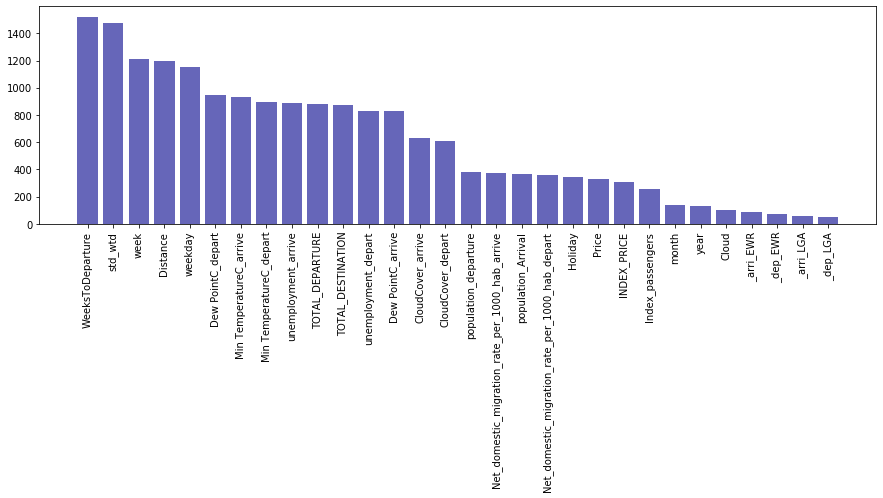

In [40]:
plt.figure(figsize=(15,4))

plt.bar(feature_names_ord, importances_ord, 
         color = 'darkblue', alpha= 0.6);
plt.xticks(rotation=90);

On peut regarder plus finement avec la librairie `shap` les importances :

In [43]:
reg2 = LGBMRegressor().fit(X[feature_names_ord],y_train)

In [44]:
shap.initjs()
explainer = shap.TreeExplainer(reg2)
shap_values = explainer.shap_values(X[feature_names_ord])
shap.force_plot(explainer.expected_value, shap_values[0,:], X[feature_names_ord].iloc[0,:])

L'explication ci-dessus montre les caractéristiques qui contribuent chacune à faire passer la sortie du modèle de la valeur de base (la sortie moyenne du modèle sur l'ensemble des données de train que nous avons passées) à la sortie du modèle. Les caractéristiques qui poussent la prédiction vers le haut sont indiquées en rouge, celles qui poussent la prédiction vers le bas sont en bleu (diagrammes de force).

### Features selection : SelectFromModel

In [45]:
from sklearn.feature_selection import SelectFromModel, RFECV
from lightgbm import LGBMRegressor


def _selectfeatures(X):
    feature_names = np.array(list(X.columns))
    select = SelectFromModel(LGBMRegressor(), threshold="0.1*mean")
    select.fit_transform(X,y_train)
    selected_features = feature_names[select.get_support()]
    return X[selected_features]

lasso_select = FunctionTransformer(_selectfeatures)

In [46]:
feature_select = list(lasso_select.fit_transform(X).columns)
len(feature_select)

42

In [47]:
np.array(X.columns)

array(['WeeksToDeparture', 'std_wtd', 'year', 'month', 'weekday', 'week',
       'Distance', 'population_Arrival', 'population_departure',
       'Net_domestic_migration_rate_per_1000_hab_depart',
       'Min TemperatureC_depart', 'Dew PointC_depart',
       'CloudCover_depart', 'TOTAL_DEPARTURE', 'unemployment_depart',
       'Net_domestic_migration_rate_per_1000_hab_arrive',
       'Min TemperatureC_arrive', 'Dew PointC_arrive',
       'CloudCover_arrive', 'TOTAL_DESTINATION', 'unemployment_arrive',
       'Holiday', 'INDEX_PRICE', 'Index_passengers', 'Price', 'Cloud',
       'Fog', '_dep_ATL', '_dep_BOS', '_dep_CLT', '_dep_DEN', '_dep_DFW',
       '_dep_DTW', '_dep_EWR', '_dep_IAH', '_dep_JFK', '_dep_LAS',
       '_dep_LAX', '_dep_LGA', '_dep_MCO', '_dep_MIA', '_dep_MSP',
       '_dep_ORD', '_dep_PHL', '_dep_PHX', '_dep_SEA', '_dep_SFO',
       '_arri_ATL', '_arri_BOS', '_arri_CLT', '_arri_DEN', '_arri_DFW',
       '_arri_DTW', '_arri_EWR', '_arri_IAH', '_arri_JFK', '_arri_LAS',
   

---
## Modèles
---

La phase finale du projet consiste à la recherche du meilleur modèle et des hyperparamètres associés. Les RMSE de chacun des modèles (hyperparamètres par défaut) sur notre jeu de données (par étapes) sont les suivants : 

In [48]:
mydata = pipeline.fit_transform(X_train)
mydata_test = pipeline.fit_transform(X_test)

X_train_select = mydata[feature_select]
X_test_select = mydata_test[feature_select]

### Modèle retenu : LightGBM

À partir de l’ensemble de nos résultats précédent sur nos Features sélectionnées, on peut conclure que le modèle **LightGBM** semble être le meilleur pour notre problématique. En résumé, il s’agit d’un modèle d’arbre optimisé qui se révèle performant autant en termes de score que de temps de calcul.

In [54]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

lgbm = LGBMRegressor(n_estimators=500, num_leaves=39, random_state=1)


scores = cross_val_score(lgbm, X_train_select, 
                         y_train, cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.3567 +/- 0.0203


In [55]:
prediction = lgbm.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.3526


$R2$ : 

In [57]:
lgbm.score(X_test_select,y_test.reshape(-1,1)).round(3) # 0.88 avec 0.2 mean

0.879

## D'autre modèles utilisés

### RandomForest et ExtraTree

Avec un Random Forests : 

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

reg = RandomForestRegressor(n_estimators=100, random_state=2)

scores = cross_val_score(reg, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4623 +/- 0.0298


In [59]:
from sklearn.metrics import mean_squared_error

prediction = reg.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.4870


On peut regarder l'ExtraTree : 

In [60]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet

boost = ExtraTreesRegressor()

scores = cross_val_score(boost, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4320 +/- 0.0244


In [61]:
from sklearn.metrics import mean_squared_error

prediction = boost.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.4326


### Stacking de modèles

On peut utiliser une méthode d'ensemble pour stacker les modèles de régressions : 

In [27]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor, ExtraTreesRegressor

estimators = [('lasso', LassoCV(random_state=1)),
               ('gradboost', GradientBoostingRegressor(n_estimators=100)),
             ("random_forest",RandomForestRegressor())]

stack = StackingRegressor(estimators=estimators, 
                          final_estimator=ExtraTreesRegressor())

stack.fit(X_train_select,y_train);

In [37]:
scores = cross_val_score(stack, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.4677 +/- 0.0244


Sur l'échantillon de Test : 

In [38]:
pred = stack.predict(X_test_select)
print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,pred))))

RMSE: 0.4747


### XGBoost

Le modèle XGBoost qui se révèle être également performant : 

In [62]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

scores = cross_val_score(xgb, X_train_select, 
                         y_train, cv=5, 
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.3825 +/- 0.0162


In [63]:
prediction = xgb.fit(X_train_select, y_train).predict(X_test_select)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

RMSE: 0.3868


### CatBoost

Un modèle qui permet de gérer davantage les variable catégorielles : 

In [128]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


cat = CatBoostRegressor()


scores = cross_val_score(cat, X_train_select, 
                         y_train, cv=5,
                         scoring='neg_mean_squared_error',
                         n_jobs=3)

print("RMSE: {:.4f} +/- {:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

RMSE: 0.3735 +/- 0.0239


In [41]:
prediction = cat.fit(X_train_select, y_train).predict(X_test_select, verbose=None)

print("RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test,prediction))))

Learning rate set to 0.057598
0:	learn: 0.9769056	total: 13.3ms	remaining: 13.3s
1:	learn: 0.9614437	total: 24.8ms	remaining: 12.4s
2:	learn: 0.9464796	total: 33.9ms	remaining: 11.3s
3:	learn: 0.9317085	total: 46.3ms	remaining: 11.5s
4:	learn: 0.9188861	total: 56ms	remaining: 11.2s
5:	learn: 0.9052902	total: 66ms	remaining: 10.9s
6:	learn: 0.8955379	total: 75.5ms	remaining: 10.7s
7:	learn: 0.8844955	total: 83.9ms	remaining: 10.4s
8:	learn: 0.8746605	total: 94.1ms	remaining: 10.4s
9:	learn: 0.8646135	total: 106ms	remaining: 10.5s
10:	learn: 0.8550427	total: 116ms	remaining: 10.4s
11:	learn: 0.8464584	total: 126ms	remaining: 10.3s
12:	learn: 0.8372817	total: 135ms	remaining: 10.3s
13:	learn: 0.8287613	total: 147ms	remaining: 10.4s
14:	learn: 0.8201171	total: 158ms	remaining: 10.4s
15:	learn: 0.8121495	total: 167ms	remaining: 10.3s
16:	learn: 0.8052212	total: 176ms	remaining: 10.2s
17:	learn: 0.7978899	total: 184ms	remaining: 10s
18:	learn: 0.7888842	total: 203ms	remaining: 10.5s
19:	lear

168:	learn: 0.4639008	total: 2.08s	remaining: 10.2s
169:	learn: 0.4631893	total: 2.1s	remaining: 10.3s
170:	learn: 0.4621462	total: 2.18s	remaining: 10.6s
171:	learn: 0.4610619	total: 2.34s	remaining: 11.3s
172:	learn: 0.4602591	total: 2.36s	remaining: 11.3s
173:	learn: 0.4593956	total: 2.38s	remaining: 11.3s
174:	learn: 0.4584769	total: 2.4s	remaining: 11.3s
175:	learn: 0.4573926	total: 2.42s	remaining: 11.3s
176:	learn: 0.4567438	total: 2.44s	remaining: 11.3s
177:	learn: 0.4558280	total: 2.46s	remaining: 11.4s
178:	learn: 0.4549629	total: 2.47s	remaining: 11.3s
179:	learn: 0.4541604	total: 2.49s	remaining: 11.3s
180:	learn: 0.4535364	total: 2.51s	remaining: 11.3s
181:	learn: 0.4522805	total: 2.53s	remaining: 11.4s
182:	learn: 0.4510845	total: 2.54s	remaining: 11.4s
183:	learn: 0.4503816	total: 2.56s	remaining: 11.4s
184:	learn: 0.4495887	total: 2.58s	remaining: 11.3s
185:	learn: 0.4487179	total: 2.59s	remaining: 11.3s
186:	learn: 0.4479977	total: 2.6s	remaining: 11.3s
187:	learn: 0.4

328:	learn: 0.3732747	total: 6.16s	remaining: 12.6s
329:	learn: 0.3729535	total: 6.2s	remaining: 12.6s
330:	learn: 0.3725125	total: 6.24s	remaining: 12.6s
331:	learn: 0.3722913	total: 6.27s	remaining: 12.6s
332:	learn: 0.3718589	total: 6.29s	remaining: 12.6s
333:	learn: 0.3716300	total: 6.33s	remaining: 12.6s
334:	learn: 0.3711904	total: 6.34s	remaining: 12.6s
335:	learn: 0.3709841	total: 6.37s	remaining: 12.6s
336:	learn: 0.3706394	total: 6.38s	remaining: 12.6s
337:	learn: 0.3703082	total: 6.39s	remaining: 12.5s
338:	learn: 0.3700217	total: 6.41s	remaining: 12.5s
339:	learn: 0.3697311	total: 6.42s	remaining: 12.5s
340:	learn: 0.3692881	total: 6.44s	remaining: 12.4s
341:	learn: 0.3690258	total: 6.47s	remaining: 12.4s
342:	learn: 0.3687033	total: 6.48s	remaining: 12.4s
343:	learn: 0.3685341	total: 6.5s	remaining: 12.4s
344:	learn: 0.3681288	total: 6.51s	remaining: 12.4s
345:	learn: 0.3678993	total: 6.52s	remaining: 12.3s
346:	learn: 0.3674608	total: 6.53s	remaining: 12.3s
347:	learn: 0.

491:	learn: 0.3291021	total: 9.34s	remaining: 9.64s
492:	learn: 0.3289721	total: 9.36s	remaining: 9.63s
493:	learn: 0.3286919	total: 9.39s	remaining: 9.62s
494:	learn: 0.3284782	total: 9.43s	remaining: 9.62s
495:	learn: 0.3283051	total: 9.49s	remaining: 9.64s
496:	learn: 0.3281172	total: 9.51s	remaining: 9.63s
497:	learn: 0.3279118	total: 9.53s	remaining: 9.61s
498:	learn: 0.3276922	total: 9.56s	remaining: 9.6s
499:	learn: 0.3274795	total: 9.58s	remaining: 9.58s
500:	learn: 0.3274475	total: 9.59s	remaining: 9.55s
501:	learn: 0.3274226	total: 9.6s	remaining: 9.52s
502:	learn: 0.3272280	total: 9.61s	remaining: 9.49s
503:	learn: 0.3268632	total: 9.62s	remaining: 9.46s
504:	learn: 0.3266199	total: 9.62s	remaining: 9.43s
505:	learn: 0.3263581	total: 9.63s	remaining: 9.4s
506:	learn: 0.3261112	total: 9.64s	remaining: 9.38s
507:	learn: 0.3258630	total: 9.65s	remaining: 9.35s
508:	learn: 0.3256098	total: 9.66s	remaining: 9.32s
509:	learn: 0.3253807	total: 9.67s	remaining: 9.29s
510:	learn: 0.3

660:	learn: 0.2981381	total: 12.6s	remaining: 6.49s
661:	learn: 0.2978358	total: 12.7s	remaining: 6.47s
662:	learn: 0.2976317	total: 12.7s	remaining: 6.45s
663:	learn: 0.2975220	total: 12.7s	remaining: 6.43s
664:	learn: 0.2973465	total: 12.7s	remaining: 6.41s
665:	learn: 0.2971999	total: 12.7s	remaining: 6.39s
666:	learn: 0.2969883	total: 12.8s	remaining: 6.38s
667:	learn: 0.2968033	total: 12.8s	remaining: 6.37s
668:	learn: 0.2966297	total: 12.9s	remaining: 6.38s
669:	learn: 0.2964410	total: 13s	remaining: 6.38s
670:	learn: 0.2962748	total: 13s	remaining: 6.37s
671:	learn: 0.2960511	total: 13s	remaining: 6.36s
672:	learn: 0.2959457	total: 13.1s	remaining: 6.35s
673:	learn: 0.2957844	total: 13.1s	remaining: 6.34s
674:	learn: 0.2955910	total: 13.2s	remaining: 6.34s
675:	learn: 0.2953677	total: 13.2s	remaining: 6.33s
676:	learn: 0.2951735	total: 13.2s	remaining: 6.32s
677:	learn: 0.2949146	total: 13.3s	remaining: 6.29s
678:	learn: 0.2948051	total: 13.3s	remaining: 6.27s
679:	learn: 0.2945

830:	learn: 0.2718278	total: 16s	remaining: 3.25s
831:	learn: 0.2717238	total: 16s	remaining: 3.23s
832:	learn: 0.2715894	total: 16s	remaining: 3.21s
833:	learn: 0.2715540	total: 16s	remaining: 3.19s
834:	learn: 0.2713970	total: 16s	remaining: 3.17s
835:	learn: 0.2713137	total: 16.1s	remaining: 3.15s
836:	learn: 0.2712018	total: 16.1s	remaining: 3.13s
837:	learn: 0.2710825	total: 16.1s	remaining: 3.11s
838:	learn: 0.2709391	total: 16.1s	remaining: 3.09s
839:	learn: 0.2707490	total: 16.1s	remaining: 3.07s
840:	learn: 0.2705353	total: 16.1s	remaining: 3.04s
841:	learn: 0.2703783	total: 16.1s	remaining: 3.02s
842:	learn: 0.2702724	total: 16.1s	remaining: 3s
843:	learn: 0.2701303	total: 16.1s	remaining: 2.98s
844:	learn: 0.2700047	total: 16.2s	remaining: 2.96s
845:	learn: 0.2698633	total: 16.2s	remaining: 2.94s
846:	learn: 0.2697355	total: 16.3s	remaining: 2.94s
847:	learn: 0.2695798	total: 16.3s	remaining: 2.93s
848:	learn: 0.2693915	total: 16.3s	remaining: 2.91s
849:	learn: 0.2692976	tot

999:	learn: 0.2515668	total: 19s	remaining: 0us
RMSE: 0.3745


In [45]:
cat.score(X_test_select, y_test).round(3)

0.864

## Parameters Tunings 

Pour le modèle LGBM qui reste le meilleur algorithme, nous pouvons utiliser une fonction GridSearchCV, mais coûteuse en calcul, ou plutôt des learning curve qui permet d'observer comment se comporte la métrique sur un échantillon de test et de train.

### Learning curve

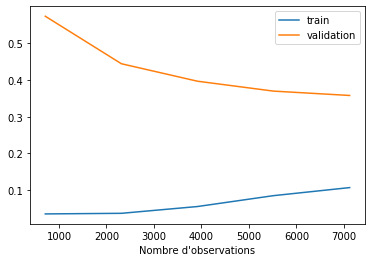

In [64]:
from sklearn.model_selection import learning_curve

N, train_score, val_score= learning_curve(lgbm,
                                          X_train_select,
                                          y_train,scoring="neg_mean_squared_error")


train_score = np.sqrt(-train_score)
val_score = np.sqrt(-val_score)

plt.plot(N,train_score.mean(axis=1), label="train")
plt.plot(N,val_score.mean(axis=1), label="validation")
plt.xlabel("Nombre d'observations")
plt.legend();

### Validation curve

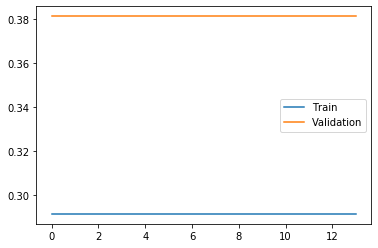

In [65]:
from sklearn.model_selection import validation_curve

lgbm_valid = LGBMRegressor()
k = np.arange(1,70,5)

train_score, val_score = validation_curve(lgbm_valid, X_train_select, y_train, cv=5, 
                                          param_name='n_leaves',
                                         param_range=k,
                                         scoring='neg_mean_squared_error')
train_score = np.sqrt(-train_score)
val_score = np.sqrt(-val_score)
train_score = train_score.mean(axis=1)
val_score = val_score.mean(axis=1)

plt.plot(train_score, label="Train")
plt.plot(val_score, label="Validation")
plt.legend();

## Ramp : soumission sur la plateforme 

In [ ]:
!ramp-test --submission submit